# Credmark Workshop for MetricsDAO

- 2023.6.20
- Join Credmark Discord: https://credmark.com/contact-us

1. Token (symbol, name, )
2. Contract (Uniswap V2)
3. Get the reserve, get the price
4. Get the reserve for the past
5. Get the reserve for a range of time.


## Initialize


In [2]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, BlockNumber

context, model_loader = create_cmf(show=True)

Credmark context created with 
- chain_id=1
- block_number=None (17519336)
- chain_to_provider_url=https://no...om/1
- model_loader_path=['/home/yangye/dev/credmark/credmark-models-py/models']
- api_url=https://gateway.credmark.com
- use_local_models=None



In [3]:
# print the chain ID, block number and block timestamp
print((context.chain_id,
       context.block_number,
       context.block_number.timestamp_datetime.isoformat()))

(1, 17519336, '2023-06-20T07:09:59+00:00')


## 1. Token


In [4]:
# WBTC token
wbtc = Token('0x2260fac5e5542a773aa44fbcfedf7c193bc2c599')
print((wbtc.symbol, wbtc.total_supply, wbtc.decimals))

# These values shall match closely with what's shown in
# https://etherscan.io/address/0x2260fac5e5542a773aa44fbcfedf7c193bc2c599#readContract
# We have shown as live, while EtherScan update some time ago.

('WBTC', 15692719544250, 8)


In [5]:
# Query the TokenTransfer table for WBTC

# We have these tables available
display(context.ledger.tables())

# columns in TokenTransfer table
display(context.ledger.TokenTransfer.columns)

['Block',
 'Contract',
 'Log',
 'Receipt',
 'Token',
 'TokenBalance',
 'TokenTransfer',
 'Trace',
 'Transaction']

['block_hash',
 'block_number',
 'block_timestamp',
 'from_address',
 'log_index',
 'token_address',
 'to_address',
 'transaction_hash',
 'value']

In [6]:
# Fetch the recent WBTC transfers

with context.ledger.TokenTransfer as q:
    df = q.select(columns=q.columns,
                  where=q.TOKEN_ADDRESS.eq(wbtc.address).and_(q.BLOCK_NUMBER.between_(
                      context.block_number - 1000, context.block_number)),
                  order_by=q.BLOCK_NUMBER.desc(),
                  limit=1).to_dataframe()

display(df)

,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0x2891b5b680e978c0a31f4895276016b7c2041045202e...,17519336,2023-06-20T07:09:59.000Z,0x4585fe77225b41b697c938b018e2ac67ac5a20c0,290,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x43f9048370a370e74ec0f30f4c811d75953cfc3e,0x25d525375f09fda6689dc93ff520570c975b77c2df4a...,9549127


## 2. Contract

- We choose an exchange pool from Uniswap V2
- https://v2.info.uniswap.org/home
- V2 pool is simple because the ratio between two tokens' reserves is the price.

For example:

- The USDC-ETH pool is composed of two tokens: USDC and ETH.
- The pool's reserves are the total amount of USDC and ETH in the pool.
- ETH's price in USDC is USDC's reserve divided by ETH's reserve.


In [7]:
eth_usdc_pool = Contract('0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc')

# Explore the pool contract
display(dir(eth_usdc_pool.abi.functions))

['DOMAIN_SEPARATOR',
 'MINIMUM_LIQUIDITY',
 'PERMIT_TYPEHASH',
 'allowance',
 'approve',
 'balanceOf',
 'burn',
 'decimals',
 'factory',
 'getReserves',
 'initialize',
 'kLast',
 'mint',
 'name',
 'nonces',
 'permit',
 'price0CumulativeLast',
 'price1CumulativeLast',
 'skim',
 'swap',
 'symbol',
 'sync',
 'token0',
 'token1',
 'totalSupply',
 'transfer',
 'transferFrom']

In [8]:
# The detail of token0/token1/getReserves function
print(eth_usdc_pool.abi.functions.token0)
print('---')
print(eth_usdc_pool.abi.functions.token1)
print('---')
print(eth_usdc_pool.abi.functions.getReserves)

Function Name: token0
Args: []
Types: []
Output: ['address']
---
Function Name: token1
Args: []
Types: []
Output: ['address']
---
Function Name: getReserves
Args: []
Types: []
Output: ['uint112', 'uint112', 'uint32']


In [9]:
token0_addr = eth_usdc_pool.functions.token0().call()
token1_addr = eth_usdc_pool.functions.token1().call()

# The addresses of two tokens
print((token0_addr, token1_addr))

# Know what these tokens are actually are
token0 = Token(token0_addr)
token1 = Token(token1_addr)
print((token0.symbol, token1.symbol))

('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
('USDC', 'WETH')


In [10]:
# Get the reserve of two tokens in this pool
reserve = eth_usdc_pool.functions.getReserves().call()
print((reserve))

# split the return tuple to three values
_reserve0, _reserve1, _block_timestamp_last = reserve

# price of ETH (as token1) = reserve0 / reserve1, scaled by each token's decimals
price_eth = token0.scaled(_reserve0) / token1.scaled(_reserve1)  # the ratio is USDC per WETH

print(price_eth)

[27192808226054, 15721677268190876471905, 1687244867]
1729.637860018426


## 3. Write a model


In [11]:
from credmark.cmf.model import Model
from credmark.cmf.types import Contract, Token


@Model.describe(
    slug='jit.uniswap-v2-reserve',
    version='1.1',
    input=Contract,
    output=dict)
class UniswapV2Reserve(Model):
    def run(self, input: Contract):
        # get the tokens in this pool
        token0_addr = input.functions.token0().call()
        token1_addr = input.functions.token1().call()
        # create the Token objects
        token0 = Token(token0_addr)
        token1 = Token(token1_addr)
        # get the reserve
        _reserve0, _reserve1, _block_timestamp_last = input.functions.getReserves().call()
        # calculate the price
        price_token1 = token0.scaled(_reserve0) / token1.scaled(_reserve1)
        # return the result
        return {'price_token1': price_token1,
                'price_token0': 1 / price_token1,
                'reserve0': _reserve0,
                'reserve1': _reserve1}


# We can save this as a file in the models/ directory of credmark-models-py, or model_loader_path shown above for create_cmf().
# Here we directly load it from the definition, with this way, it can only be used in this notebook.
context.add_model(UniswapV2Reserve)

In [12]:
context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

# model checks for validity of the input
# try run above with a shorter address, i.e. 0xB4e16d0168e52d35CaCD2c6185b44
# You will get a ModelInputError

{'price_token1': 1729.637860018426,
 'price_token0': 0.0005781557071081613,
 'reserve0': 27192808226054,
 'reserve1': 15721677268190876471905}

In [13]:
# We can run model on earlier block
# Model is a re-usable piece of algorithm to run for a chain_id, a block_number

earlier_block = context.block_number - 1_000

display(earlier_block.timestamp_datetime)

context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                  block_number=earlier_block)

datetime.datetime(2023, 6, 20, 3, 48, 35, tzinfo=datetime.timezone.utc)

{'price_token1': 1736.340892169329,
 'price_token0': 0.0005759237742484034,
 'reserve0': 27245325501974,
 'reserve1': 15691230693723141732753}

## 4. Scale up the model for more blocks


In [14]:
# Run the model for 1000 blocks will take a while, how could we speed up?

for offset in range(10):
    context.run_model('jit.uniswap-v2-reserve',
                      {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                      block_number=context.block_number - offset)

In [15]:
# Uniswap V2 pool's reserve changes with Mint/Burn/Swap, it kept a record of these events.
# Event Sync occurs together with Mint/Burn to record the reserve, that's we need.

eth_usdc_pool.abi.events.Sync

Event Name: Sync
Args: ['reserve0', 'reserve1']
Types: ['uint112', 'uint112']

In [16]:
# Let's query the ledger database for the event log for Sync.
# Querying this data only takes less than a second.

with eth_usdc_pool.ledger.events.Sync as q:
    df = q.select(columns=q.columns,
                  where=q.BLOCK_NUMBER.ge(context.block_number-1000),
                  order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

# Note: Because we limit each query to return 5000 results
# We may query multiple times to get all the results till we have exhausted all the results.

display(df)

,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_reserve0,evt_reserve1
0,17518347,2023-06-20T03:50:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,128,"Sync(uint112,uint112)",0xd9cadafabae0a054c62ba565c488d5cce63a8f1489b7...,27245239494297,15691280376795025696302
1,17518354,2023-06-20T03:52:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,135,"Sync(uint112,uint112)",0x0c4c16b21c85e9f0028e9f48f8242eba7cf3c2e3a09f...,27244674945230,15691606501191055541068
2,17518372,2023-06-20T03:55:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,117,"Sync(uint112,uint112)",0x375c9c864e97655871365cafbe5be421cf525ba529bb...,27244523350372,15691694075659421494106
3,17518395,2023-06-20T04:00:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,96,"Sync(uint112,uint112)",0x98476463a149638400c4bb186e358519a79f57cfe21c...,27244423296709,15691751875953624994110
4,17518395,2023-06-20T04:00:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,209,"Sync(uint112,uint112)",0x4caa321f61b892e8cd74ec7aafb63d173b88117b4b77...,27244673296709,15691608318744472414745
...,...,...,...,...,...,...,...,...
64,17519290,2023-06-20T07:00:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,24,"Sync(uint112,uint112)",0xc8dfdcc7dce796ab27a2b6f0cbb32c4dfeda8b5caac8...,27190140477414,15723215166018118603466
65,17519304,2023-06-20T07:03:35.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,268,"Sync(uint112,uint112)",0xe606d357f654ed1dc33d65020e282134d384db2b2a76...,27190154841653,15723206884547634163540
66,17519308,2023-06-20T07:04:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,238,"Sync(uint112,uint112)",0x584701ce0f51c46c29f01dff94203ac3c438363fea02...,27190249720619,15723152183828169358479
67,17519320,2023-06-20T07:06:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,115,"Sync(uint112,uint112)",0xdd6c574c57d82dc333c46a462920f25f5788d9e61f0c...,27192749720619,15721710992038822134108


,block_number,reserve0,reserve1,price_token1,price_token0
0,17518336,2.724524e+13,15691280376795025696302,1736.329913,0.000576
1,17518337,2.724524e+13,15691280376795025696302,1736.329913,0.000576
2,17518338,2.724524e+13,15691280376795025696302,1736.329913,0.000576
3,17518339,2.724524e+13,15691280376795025696302,1736.329913,0.000576
4,17518340,2.724524e+13,15691280376795025696302,1736.329913,0.000576
...,...,...,...,...,...
996,17519332,2.719281e+13,15721677268190876471905,1729.637860,0.000578
997,17519333,2.719281e+13,15721677268190876471905,1729.637860,0.000578
998,17519334,2.719281e+13,15721677268190876471905,1729.637860,0.000578
999,17519335,2.719281e+13,15721677268190876471905,1729.637860,0.000578


<Axes: xlabel='block_number'>

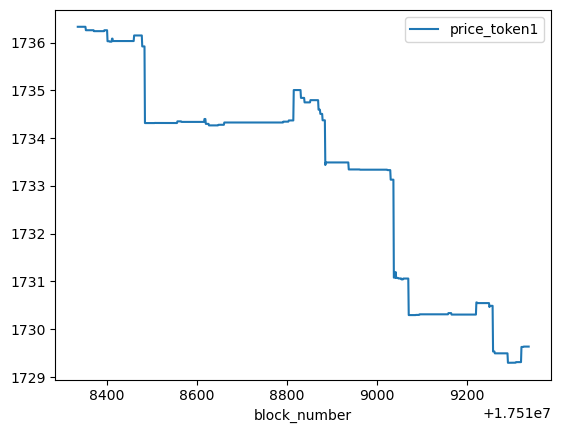

In [17]:
import pandas as pd

df_clean = (df
            .drop_duplicates(subset=['block_number'], keep='last')
            .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
            .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
            .assign(block_number=lambda x: x.block_number.apply(int),
                    reserve0=lambda x: x.reserve0.apply(int),
                    reserve1=lambda x: x.reserve1.apply(int),))

df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
df_clean['price_token0'] = 1 / df_clean['price_token1']

df_clean = (df_clean
            .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
            .sort_values('block_number')
            .fillna(method='ffill')
            .fillna(method='bfill'))

display(df_clean)

df_clean.plot('block_number', 'price_token1')

## Summary

What we have go through in CMF

- Initialize context in cmf
- Token: create it from address: query attributes, name, symbol, decimals, etc.
- Contract: create it from address, make web3 call.
- Write a model with web3 call
- Query ledger DB to get decoded event log
- Post-process the data in DataFrame
